https://en.wikipedia.org/wiki/Scale-invariant_feature_transform
https://kushalvyas.github.io/BOV.html
http://127.0.0.1:5500/image-feature-extraction.html
https://www.geeksforgeeks.org/feature-extraction-in-image-processing-techniques-and-applications/

### The main goal of this exercise is to get a feeling and understanding on the importance of representation and extraction of information from complex media content, in this case images. 

1. Start Simple with Colour Histograms
2. Explore Key Point-Based Feature Extraction
    - Explore Key Point-Based Feature Extraction: Once you’re comfortable with simple features, try using SIFT for key point detection and descriptor extraction. SIFT is robust to scale and rotation, which makes it ideal for finding distinctive features in images.
        - Visual Bag of Words: After extracting SIFT features, apply a bag-of-words approach to cluster these descriptors into visual “words.” This converts a variable number of key points into a fixed-length feature vector suitable for classifiers.

        

3. Then, try to use deep learning approaches, such as convolutional neural networks (for images) or recurrent neural networks (for text), or other approaches (but likely not just simple MLPs), and see
how your performance differs. Try at least two different architectures, they can be (reusing or be based on )existing, well-known ones.

Compare not just the overall measures, but perform a detailed comparison and analysis per class (confusion matrix), to identify if the two approaches lead to different types of errors in the different classes, and also try to identify other patterns.

For images, you can base your DL implementation on the tutorial provided by colleagues at the institute, available at https://github.com/tuwien-musicir/DL_Tutorial/blob/master/Car_recognition.ipynb (you can also check the rest of the repository for interesting code; credit to Thomas Lidy (http://www.ifs.tuwien.ac.at/~lidy/)). Mind also that you will find plenty of examples on how to create and train CNNs / RNNs in various frameworks - tensorflow, keras, pytorch, ....

Also perform a detailed comparison of runtime, considering both time for training and testing, including also the feature extraction components.
For the datasets you shall work with, pick two text/image datasets, from the list of suggestions below.

In [16]:
import pandas as pd
import numpy as np
import time
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

import io
from PIL import Image

# Scikit-learn imports
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
import seaborn as sns

# Torch and torchvision 
import torch
from torchvision import datasets, transforms

In [5]:
import pandas as pd

splits = {'train': 'data/train-00000-of-00001-1359597a978bc4fa.parquet', 'valid': 'data/valid-00000-of-00001-70d52db3c749a935.parquet'}
df = pd.read_parquet("hf://datasets/zh-plus/tiny-imagenet/" + splits["train"])

# Pipeline

### Helper Functions

In [ ]:



def extract_color_histogram(image, bins=8):
    """
    Extracts a normalized color histogram from an image.
    
    Args:
        image (numpy.ndarray): Image array in RGB format.
        bins (int): Number of bins per channel.
        
    Returns:
        np.ndarray: Flattened concatenated normalized histogram for each channel.
    """
    # Ensure image is in uint8 format
    if image.dtype != np.uint8:
        image = (255 * image).astype("uint8")
    
    # If image is not in 3 channels, convert (this might happen with grayscale images)
    if len(image.shape) != 3 or image.shape[2] != 3:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    
    chans = cv2.split(image)
    features = []
    
    for chan in chans:
        # Compute histogram for the channel
        hist = cv2.calcHist([chan], [0], None, [bins], [0, 256])
        # Normalize histogram
        hist = cv2.normalize(hist, hist).flatten()
        features.extend(hist)
        
    return np.array(features)



### Experiment Runner Function


In [ ]:

def run_experiment(X_images, y_labels, dataset_name, bins_values=[8, 16]):
    """
    Run experiments on a given dataset using two histogram configurations.
    
    Args:
        X_images (list): List of images as numpy arrays in RGB format.
        y_labels (list or array): Corresponding labels.
        dataset_name (str): Name of the dataset (for printing/plotting).
        bins_values (list): List of bin counts to try (e.g. [8, 16]).
    """
    results = {}
    
    for bins in bins_values:
        print(f"\n==== Running experiment on {dataset_name} with {bins} bins per channel ====")
        t0 = time.time()
        # Extract features for all images; use tqdm for progress
        features = []
        for img in tqdm(X_images, desc="Extracting features"):
            feat = extract_color_histogram(img, bins=bins)
            features.append(feat)
        features = np.array(features)
        extraction_time = time.time() - t0
        print(f"Feature extraction time: {extraction_time:.2f} sec")
        
        # Split into train and test sets
        X_train, X_test, y_train, y_test = train_test_split(
            features, y_labels, test_size=0.3, random_state=42, stratify=y_labels
        )
        
        # Train classifier and measure training time
        clf = LogisticRegression(max_iter=500, solver="lbfgs", multi_class="multinomial")
        t_train = time.time()
        clf.fit(X_train, y_train)
        train_time = time.time() - t_train
        print(f"Training time: {train_time:.2f} sec")
        
        # Test classifier and measure prediction time
        t_test = time.time()
        y_pred = clf.predict(X_test)
        test_time = time.time() - t_test
        print(f"Testing time: {test_time:.2f} sec")
        
        # Compute overall accuracy
        acc = accuracy_score(y_test, y_pred)
        print(f"Overall Accuracy: {acc:.4f}")
        
        # Compute confusion matrix and classification report
        cm = confusion_matrix(y_test, y_pred)
        report = classification_report(y_test, y_pred, output_dict=True)
        
        results[bins] = {
            "extraction_time": extraction_time,
            "train_time": train_time,
            "test_time": test_time,
            "accuracy": acc,
            "confusion_matrix": cm,
            "classification_report": report,
            "model": clf,
        }
        
        # Plot the confusion matrix for visual inspection
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
        plt.title(f"{dataset_name} Confusion Matrix (bins={bins})")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.show()
        
        # Also display a text report
        print(f"Classification Report (bins={bins}):")
        print(classification_report(y_test, y_pred))
    
    return results



# 1. Tiny ImageNet Experiment


In [18]:

def run_tiny_imagenet_experiment():
    # Define the parquet splits (update paths if needed)
    splits = {
        'train': 'data/train-00000-of-00001-1359597a978bc4fa.parquet',
        'valid': 'data/valid-00000-of-00001-70d52db3c749a935.parquet'
    }
    # Load training data from Tiny ImageNet (here we use the train split)
    # Note: The dataset from Hugging Face hub is accessed via "hf://datasets/..."
    try:
        df = pd.read_parquet("hf://datasets/zh-plus/tiny-imagenet/" + splits["train"])
    except Exception as e:
        print("Error loading Tiny ImageNet parquet file. Please ensure the path is correct.")
        raise e
    
    # Assume the dataframe has at least two columns: 'image' and 'label'
    # Here we assume that the 'image' column contains raw image data that can be converted to a numpy array.
    # (You might need to adjust this code based on the actual data format.)
# Loading Tiny ImageNet images with proper decoding for dict format
    X_images = []
    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Loading Tiny ImageNet images"):
        img = row['image']
        # Check if the image is stored as a dict with keys 'bytes' and 'path'
        if isinstance(img, dict):
            if set(img.keys()) == {"bytes", "path"}:
                # Decode the image bytes using PIL
                try:
                    pil_img = Image.open(io.BytesIO(img["bytes"]))
                    pil_img = pil_img.convert("RGB")  # Ensure RGB format
                    img = np.array(pil_img)
                except Exception as e:
                    raise ValueError(f"Error decoding image bytes: {e}")
            else:
                raise ValueError("Unknown image dict format: " + str(img.keys()))
        elif not isinstance(img, np.ndarray):
            img = np.array(img)
        X_images.append(img)
    
    y_labels = df['label'].tolist()
    
    print(f"Tiny ImageNet: Loaded {len(X_images)} images.")
    
    # Run the experiment using two histogram configurations: 8 and 16 bins per channel.
    tiny_results = run_experiment(X_images, y_labels, dataset_name="Tiny ImageNet", bins_values=[8, 16])
    return tiny_results



# 2. CIFAR-10 Experiment


In [ ]:

def run_cifar10_experiment():
    # Define a transform to convert PIL images to numpy arrays
    transform = transforms.Compose([
        transforms.ToTensor(),  # Converts to [0,1] tensor in shape (C, H, W)
        # We'll transpose later to get HxWxC and convert to numpy
    ])
    
    # Download and load CIFAR-10 training set (we will use the train split for simplicity)
    cifar10_train = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    
    X_images = []
    y_labels = []
    for img, label in tqdm(cifar10_train, desc="Loading CIFAR-10 images"):
        # img is a tensor of shape (C, H, W); convert to numpy and then transpose to (H, W, C)
        img_np = img.permute(1, 2, 0).numpy()
        # Convert to uint8 format (0-255)
        img_np = (img_np * 255).astype(np.uint8)
        X_images.append(img_np)
        y_labels.append(label)
    
    print(f"CIFAR-10: Loaded {len(X_images)} images.")
    
    # Run the experiment using two histogram configurations: 8 and 16 bins per channel.
    cifar_results = run_experiment(X_images, y_labels, dataset_name="CIFAR-10", bins_values=[8, 16])
    return cifar_results



# Main: Run Both Experiments


Starting experiments...



Loading Tiny ImageNet images: 100%|██████████| 100000/100000 [00:07<00:00, 13899.54it/s]


Tiny ImageNet: Loaded 100000 images.

==== Running experiment on Tiny ImageNet with 8 bins per channel ====


Extracting features: 100%|██████████| 100000/100000 [00:01<00:00, 56309.54it/s]
/Users/gerhardkarbeutz/DataScienceProjects/deep-learning-image/ex3-venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Feature extraction time: 1.79 sec
Training time: 4.53 sec
Testing time: 0.02 sec
Overall Accuracy: 0.0591


/Users/gerhardkarbeutz/DataScienceProjects/deep-learning-image/ex3-venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/gerhardkarbeutz/DataScienceProjects/deep-learning-image/ex3-venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/gerhardkarbeutz/DataScienceProjects/deep-learning-image/ex3-venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samp

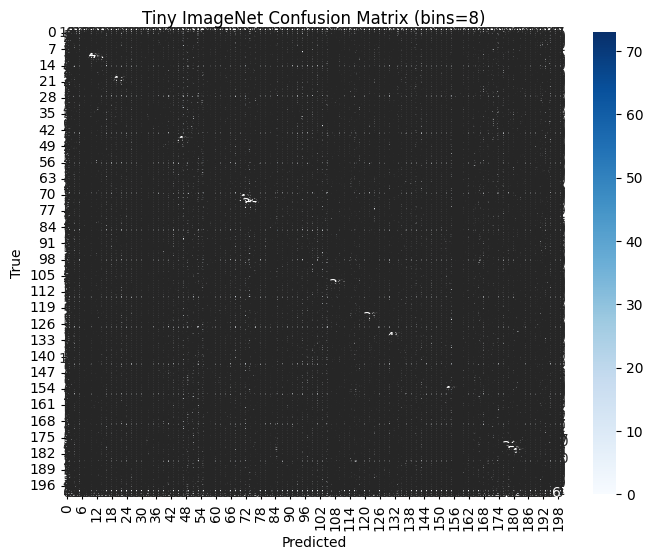

/Users/gerhardkarbeutz/DataScienceProjects/deep-learning-image/ex3-venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/gerhardkarbeutz/DataScienceProjects/deep-learning-image/ex3-venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/gerhardkarbeutz/DataScienceProjects/deep-learning-image/ex3-venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samp

Classification Report (bins=8):
              precision    recall  f1-score   support

           0       0.10      0.12      0.11       150
           1       0.02      0.03      0.02       150
           2       0.02      0.03      0.03       150
           3       0.00      0.00      0.00       150
           4       0.02      0.01      0.01       150
           5       0.00      0.00      0.00       150
           6       0.04      0.01      0.01       150
           7       0.01      0.01      0.01       150
           8       0.05      0.20      0.08       150
           9       0.00      0.00      0.00       150
          10       0.04      0.02      0.03       150
          11       0.04      0.28      0.07       150
          12       0.18      0.49      0.26       150
          13       0.08      0.11      0.09       150
          14       0.00      0.00      0.00       150
          15       0.02      0.01      0.01       150
          16       0.05      0.03      0.04      

Extracting features: 100%|██████████| 100000/100000 [00:01<00:00, 52456.81it/s]
/Users/gerhardkarbeutz/DataScienceProjects/deep-learning-image/ex3-venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Feature extraction time: 1.92 sec
Training time: 4.83 sec
Testing time: 0.02 sec
Overall Accuracy: 0.0576


/Users/gerhardkarbeutz/DataScienceProjects/deep-learning-image/ex3-venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/gerhardkarbeutz/DataScienceProjects/deep-learning-image/ex3-venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/gerhardkarbeutz/DataScienceProjects/deep-learning-image/ex3-venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samp

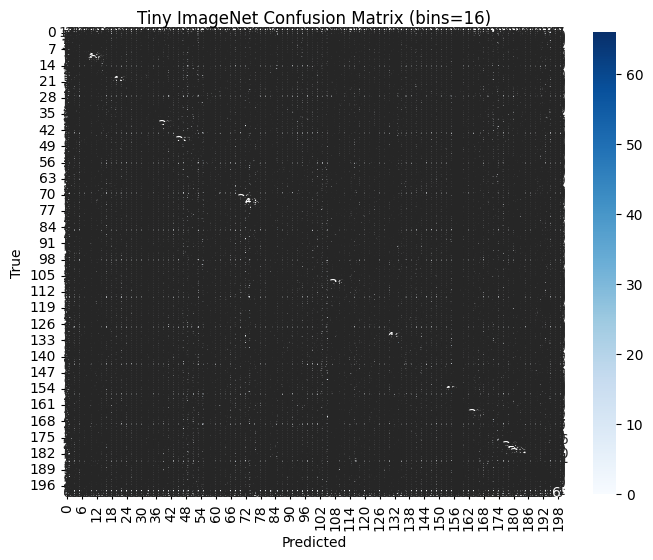

Classification Report (bins=16):
              precision    recall  f1-score   support

           0       0.09      0.12      0.10       150
           1       0.03      0.10      0.05       150
           2       0.03      0.05      0.04       150
           3       0.02      0.01      0.01       150
           4       0.01      0.01      0.01       150
           5       0.00      0.00      0.00       150
           6       0.06      0.01      0.02       150
           7       0.02      0.01      0.02       150
           8       0.04      0.13      0.06       150
           9       0.00      0.00      0.00       150
          10       0.04      0.03      0.03       150
          11       0.04      0.31      0.07       150
          12       0.19      0.44      0.27       150
          13       0.09      0.11      0.10       150
          14       0.00      0.00      0.00       150
          15       0.03      0.03      0.03       150
          16       0.04      0.03      0.03     

/Users/gerhardkarbeutz/DataScienceProjects/deep-learning-image/ex3-venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/gerhardkarbeutz/DataScienceProjects/deep-learning-image/ex3-venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/gerhardkarbeutz/DataScienceProjects/deep-learning-image/ex3-venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samp

CIFAR-10: Loaded 50000 images.

==== Running experiment on CIFAR-10 with 8 bins per channel ====


Extracting features: 100%|██████████| 50000/50000 [00:00<00:00, 67541.74it/s]
/Users/gerhardkarbeutz/DataScienceProjects/deep-learning-image/ex3-venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Feature extraction time: 0.75 sec
Training time: 0.36 sec
Testing time: 0.00 sec
Overall Accuracy: 0.2934


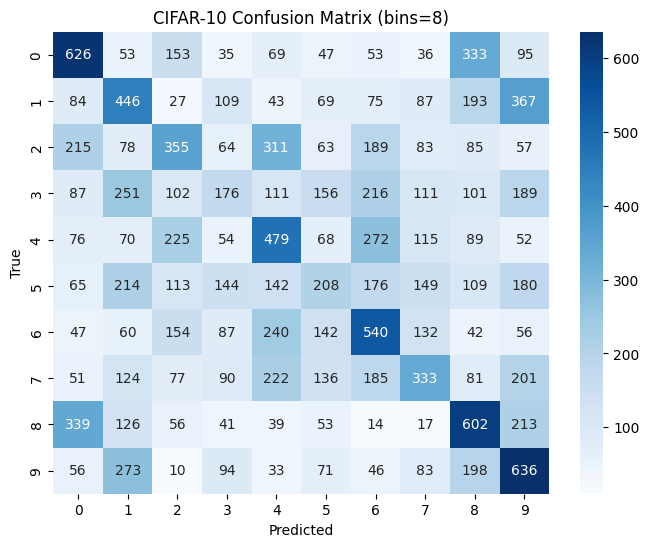

Classification Report (bins=8):
              precision    recall  f1-score   support

           0       0.38      0.42      0.40      1500
           1       0.26      0.30      0.28      1500
           2       0.28      0.24      0.26      1500
           3       0.20      0.12      0.15      1500
           4       0.28      0.32      0.30      1500
           5       0.21      0.14      0.17      1500
           6       0.31      0.36      0.33      1500
           7       0.29      0.22      0.25      1500
           8       0.33      0.40      0.36      1500
           9       0.31      0.42      0.36      1500

    accuracy                           0.29     15000
   macro avg       0.28      0.29      0.28     15000
weighted avg       0.28      0.29      0.28     15000


==== Running experiment on CIFAR-10 with 16 bins per channel ====


Extracting features: 100%|██████████| 50000/50000 [00:00<00:00, 63405.36it/s]
/Users/gerhardkarbeutz/DataScienceProjects/deep-learning-image/ex3-venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Feature extraction time: 0.80 sec
Training time: 0.52 sec
Testing time: 0.00 sec
Overall Accuracy: 0.2969


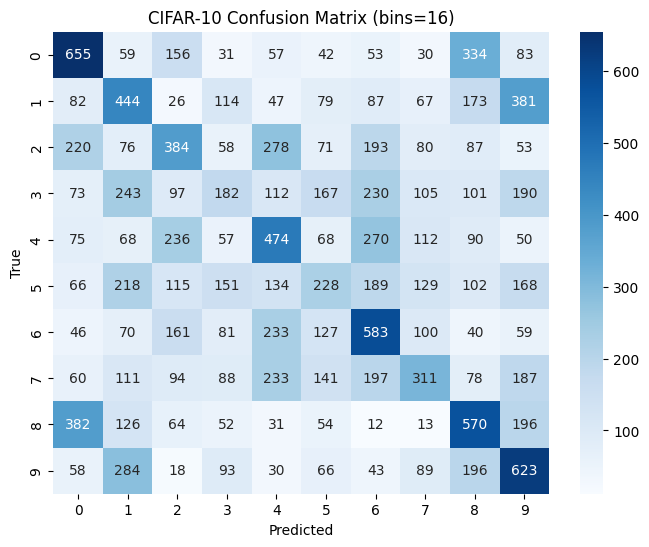

Classification Report (bins=16):
              precision    recall  f1-score   support

           0       0.38      0.44      0.41      1500
           1       0.26      0.30      0.28      1500
           2       0.28      0.26      0.27      1500
           3       0.20      0.12      0.15      1500
           4       0.29      0.32      0.30      1500
           5       0.22      0.15      0.18      1500
           6       0.31      0.39      0.35      1500
           7       0.30      0.21      0.25      1500
           8       0.32      0.38      0.35      1500
           9       0.31      0.42      0.36      1500

    accuracy                           0.30     15000
   macro avg       0.29      0.30      0.29     15000
weighted avg       0.29      0.30      0.29     15000


Experiments completed.


In [19]:

if __name__ == "__main__":
    print("Starting experiments...\n")
    
    # Run Tiny ImageNet experiment (if the parquet file is available)
    try:
        tiny_results = run_tiny_imagenet_experiment()
    except Exception as e:
        print("Tiny ImageNet experiment could not be run:", e)
        tiny_results = None
    
    # Run CIFAR-10 experiment
    cifar_results = run_cifar10_experiment()
    
    # (Optional) Further analysis: compare per-class errors across approaches, print runtime comparisons, etc.
    # For example, you could compare tiny_results[8]["accuracy"] vs. tiny_results[16]["accuracy"]
    print("\nExperiments completed.")
